Fix some dependency issues

In [ ]:
# !pip uninstall networkx -y
# !pip install networkx==2.6.3

Found existing installation: networkx 3.0
Uninstalling networkx-3.0:
  Successfully uninstalled networkx-3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.6 MB/s eta 0:00:00


In [1]:
import numpy as np

# Load Graph

**Load data for Caltech graph network (upload file first)**

*   G <- Total graph
*   H <- Subgraph of size N (first N Nodes)
*   adj_list <- Adjacency list for H




## IMPORTANT NOTE

This code template converts site nodes into numbers for ease of computation. Specifically, they are numbered 0 to N - 1 so they match up with indices in an array.


 *nodes_to_idx* can be called to convert a site URL to the index that it occupies in an array of PageRanks. *nodes[i]* for an index i will give the site URL


In [2]:
# Number of nodes
N = 200

In [4]:
import pickle
import networkx as nx

f = open('nx_caltech_2500.pkl', 'rb')
G = pickle.load(f)

nodes = list(G.nodes())[:N]
H = G.subgraph(nodes)

nodes_to_idx = {}
for i in range(len(nodes)):
  nodes_to_idx[nodes[i]] = i

adj_list = {}
for i in range(len(nodes)):
  adj_list[i] = []
  for j in nx.neighbors(H, nodes[i]):
    adj_list[i].append(nodes_to_idx[j])

# Set Parameters

In [36]:
# TODO: Fill in alpha values
alphas = [0.25, 0.45, 0.65, 0.85, 0.95]

# When the max difference is < tolerance, we've "converged"
tolerance = 1e-3

# How many times we run each process (to magnify time differences)
iter = 25

# Potentially Useful Visualizations

In [37]:
import matplotlib.pyplot as plt
from matplotlib import colors

# Plot graph {H} with node colors according to value array {v}
# Darker blue means larger value
# vmin and vmax are the bounds you want to set for the gradient
# See matplotlib vmin/vmax + colormap documentation for more details
def intensity_graph(H, v, vmin=None, vmax=None, title=""):
  vmin = vmin if vmin else np.min(v)
  vmax = vmax if vmax else np.max(v)
  plt.figure()
  plt.title(title)
  nx.draw(
    H, 
    node_color=v, cmap=plt.cm.Blues, node_size=50, vmin=vmin, vmax=vmax,
    width=0.1, alpha=0.4, edge_color='grey'
  )
  plt.show()

# Let M = len(alphas) and N = # of nodes
# pi_matrix is an N x M matrix
# where row i is the PageRank of the N nodes (labelled 0 to N - 1) 
# at alpha = alphas[i]
# Each row has their intensity visualized as a 1D heatmap
# 
# See IMPORTANT NOTE section for how labelling can be converted to URLs
def draw_heatmap(alphas, pi_matrix):
  eps = 0.5
  extent = [-eps, len(pi_matrix[0]) + eps, 0, 1]
  M = len(alphas)
  fig, axs = plt.subplots(len(alphas), figsize=(6, 4 * M))
  norm = colors.Normalize(np.min(pi_matrix), np.max(pi_matrix))
  for i in range(len(alphas)):
    axs[i].imshow(pi_matrix[i][np.newaxis, :], cmap="Blues", aspect="auto", extent=extent, norm=norm)
    axs[i].set_yticks([])
    axs[i].set_title("Alpha: {}".format(alphas[i]))
    axs[i].set_xlim(extent[0], extent[1])
  fig.show()

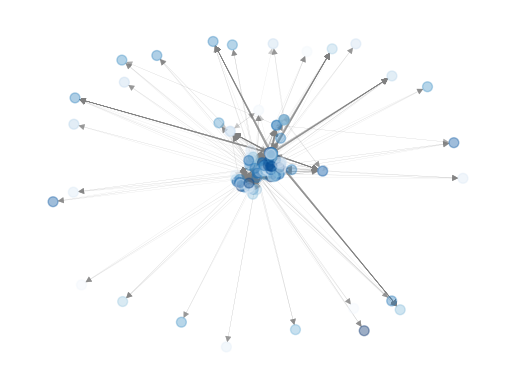

In [38]:
intensity_graph(H, np.random.rand(N))

/var/folders/sg/4dp480wd1cjd288xvby34rpr0000gn/T/ipykernel_29900/2876918579.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


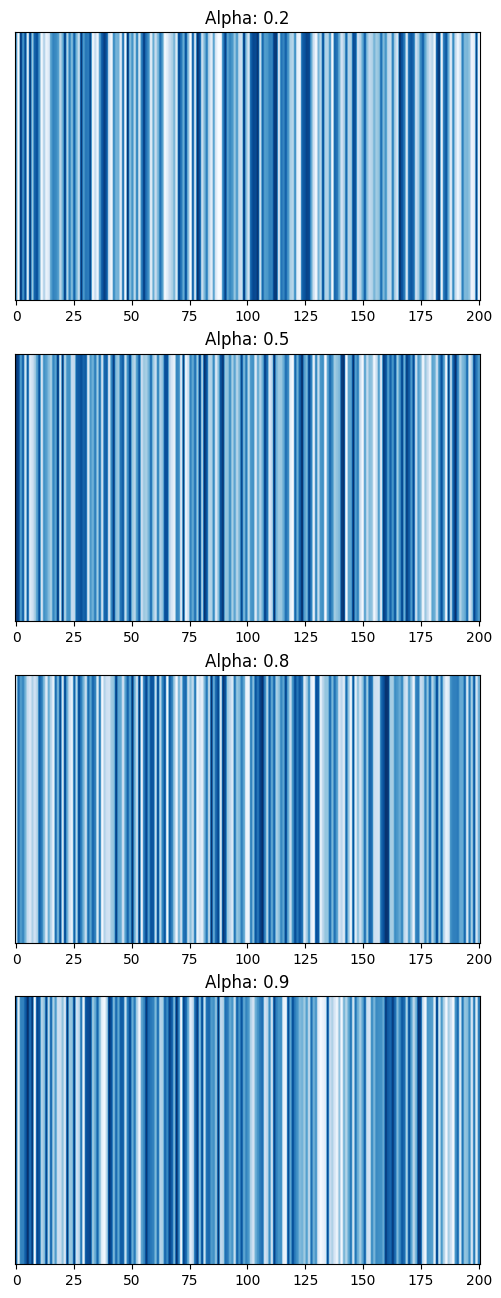

In [39]:
draw_heatmap([0.2, 0.5, 0.8, 0.9], np.random.rand(4, N))

# Random Surf

In [51]:
import numpy as np
import time
from tqdm import tqdm

# TODO:
# Perform one random surf until "converge" using alpha
# Return final distribution of PageRank
def random_surf(alpha):
  curr_node = nodes_to_idx[np.random.choice(nodes)]
  visits = np.zeros(N)
  visits[curr_node] += 1
  old_page_rank = N * visits / 1
  i = 1
  while True:
    if np.random.random() <= alpha:
      neighbors = list(H.neighbors(nodes[curr_node]))
      if len(neighbors) != 0:
        curr_node = nodes_to_idx[np.random.choice(neighbors)]
    else:
      curr_node = nodes_to_idx[np.random.choice(nodes)]
    visits[curr_node] += 1
    i += 1
    new_page_rank = N * visits / i
    if np.max(np.abs(old_page_rank - new_page_rank)) < tolerance:
      break
    old_page_rank = new_page_rank
  return new_page_rank



## RESULTS WILL BE STORED IN THESE ARRAYS
# Final PageRank values (averaged over each alpha) 
surf_pis = []
# Time taken (averaged over each alpha)
surf_times = []

# Iterate over alphas
for alpha in alphas:
  pis = []

  # Perform process at alpha level {iter} times
  # Time whole process
  start = time.time()
  for _ in tqdm(range(iter)):
    pis.append(random_surf(alpha))
  end = time.time()

  # Record average time + final value
  pis = np.array(pis)
  pi_avg = np.average(pis, axis=0)
  surf_pis.append(pi_avg)
  surf_times.append((end - start) / iter)

100%|██████████| 25/25 [04:04<00:00,  9.76s/it]


## Random Surf Visualizations

/var/folders/sg/4dp480wd1cjd288xvby34rpr0000gn/T/ipykernel_29900/2876918579.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


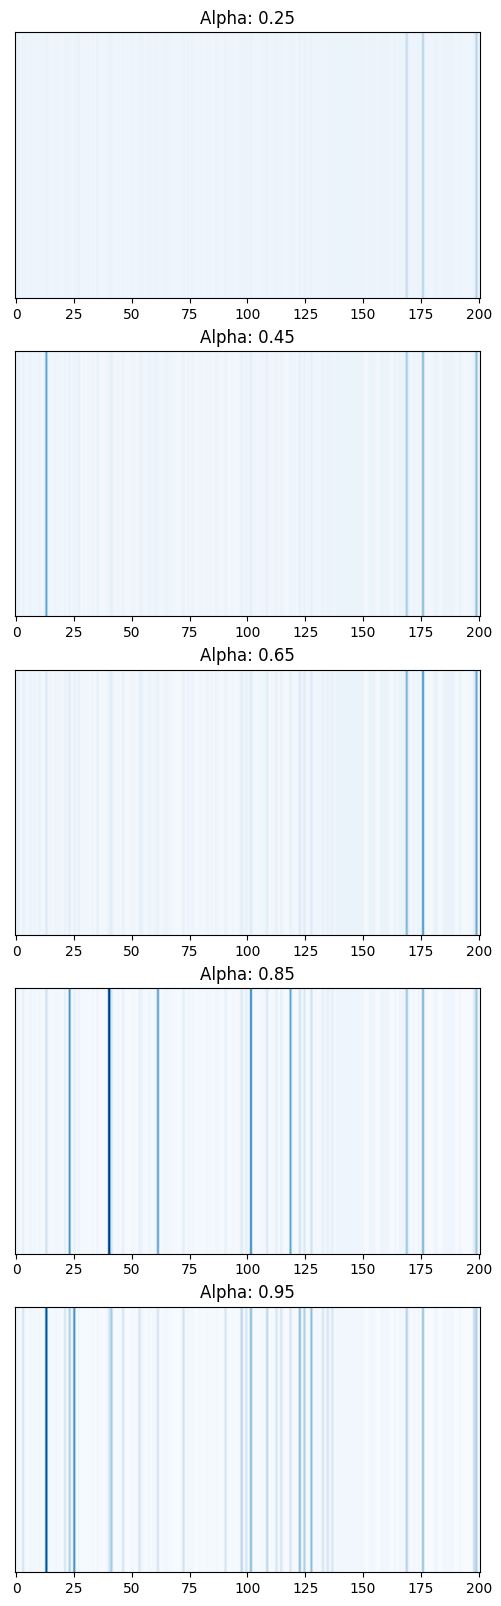

In [52]:
# TODO: Create visualizations here

# for pi in surf_pis:
#     intensity_graph(H, pi)

draw_heatmap(alphas, surf_pis)

# Matrix Iterations

In [89]:
P = np.zeros((N, N))
for i, row in enumerate(P):
    neighbors = adj_list[i]
    k = len(neighbors)
    if k != 0:
        P[i, neighbors] = 1/k
    else:
        P[i, i] = k


In [95]:
# TODO:
# Calculate PageRank via repeated multiplication of matrix using {alpha}

# TIPS:
# See np.linalg.eig for SVD decomposition

# Like Q1 on HW4, apply diagonalization with the focus on taking the diagonal
# matrix to a high power and then applying the other transforms

# Certain decompositions may carry imaginary numbers due to precision
# These numbers should die out with multiple applications of G
# So they should disappear as you take G^n for large n

def matrix_iterations(alpha):
  bigG = P * alpha + (1-alpha)/N * np.ones((N, N))
  pi0 = np.ones(N) * 1/N
  i = 1
  old_pi = (pi0 @ np.linalg.matrix_power(bigG, i))
  old_pi = old_pi / sum(old_pi)
  while True:
    i += 1
    pi = pi0 @ np.linalg.matrix_power(bigG, i)
    pi = pi / sum(pi)
    if np.max(np.abs(old_pi - pi)) < tolerance:
      break
    old_pi = pi
  return pi

# Note that as described, the PageRanks will be a factor of N off from random surf approximation
matrix_pis = []
matrix_times = []
for alpha in alphas:
  pis = []

  # Even though result is the same, do multiple to average out runtime
  start = time.time()
  for _ in tqdm(range(iter)):
    pis.append(matrix_iterations(alpha))
  end = time.time()

  matrix_times.append((end - start) / iter)
  # Don't really need to have average here since we have deterministic results
  matrix_pis.append(np.average(pis, axis=0))


100%|██████████| 25/25 [00:02<00:00,  8.69it/s]


# Matrix Iterations Visualizations

/var/folders/sg/4dp480wd1cjd288xvby34rpr0000gn/T/ipykernel_29900/2876918579.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


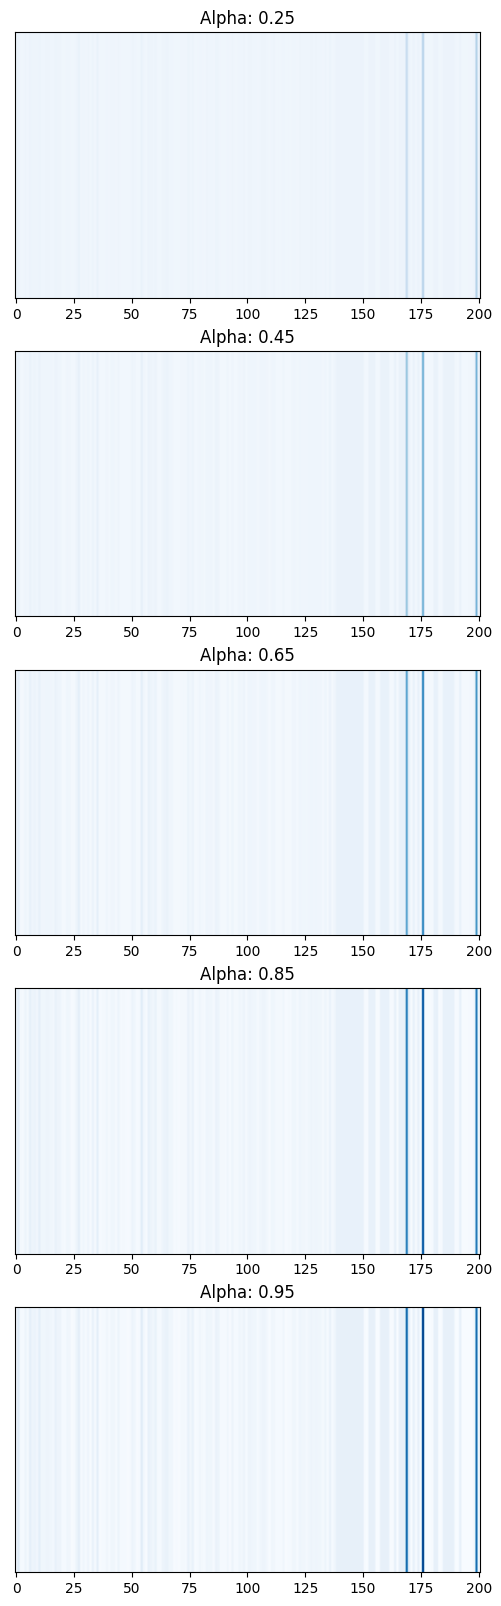

In [96]:
draw_heatmap(alphas, matrix_pis)

# Diagonalization

In [114]:
# TODO:
# Calculate PageRank via repeated multiplication of matrix using {alpha}

# TIPS:
# See np.linalg.eig for SVD decomposition

# Like Q1 on HW4, apply diagonalization with the focus on taking the diagonal
# matrix to a high power and then applying the other transforms

# Certain decompositions may carry imaginary numbers due to precision
# These numbers should die out with multiple applications of G
# So they should disappear as you take G^n for large n

# Calculate PageRank via diagonalization
def diagonalize(alpha):
  bigG = P * alpha + (1-alpha)/(N)
  eigval, S = np.linalg.eig(bigG)
  raiseme = np.diag(eigval)

  pi0 = np.ones(N) * 1/N
  i = 1
  old_pi = np.real((pi0 @ S @ np.linalg.matrix_power(raiseme, i) @ np.linalg.inv(S)))
  old_pi = old_pi / sum(old_pi)
  while True:
    i += 1
    pi = np.real((pi0 @ S @ np.linalg.matrix_power(raiseme, i) @ np.linalg.inv(S)))
    pi = pi / sum(pi)
    if np.max(np.abs(old_pi - pi)) < tolerance:
      break
    old_pi = pi
  return pi

# Note that as described, the PageRanks will be a factor of N off from random surf approximation
diagonalize_pis = []
diagonalize_times = []
for alpha in alphas:
  pis = []

  # Even though result is the same, do multiple to average out runtime
  start = time.time()
  for _ in tqdm(range(iter)):
    pis.append(diagonalize(alpha))
  end = time.time()

  diagonalize_times.append((end - start) / iter)
  # Don't really need to have average here since we have deterministic results
  diagonalize_pis.append(np.average(pis, axis=0))


100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


## Diagonalization Visualizations

/var/folders/sg/4dp480wd1cjd288xvby34rpr0000gn/T/ipykernel_29900/2876918579.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


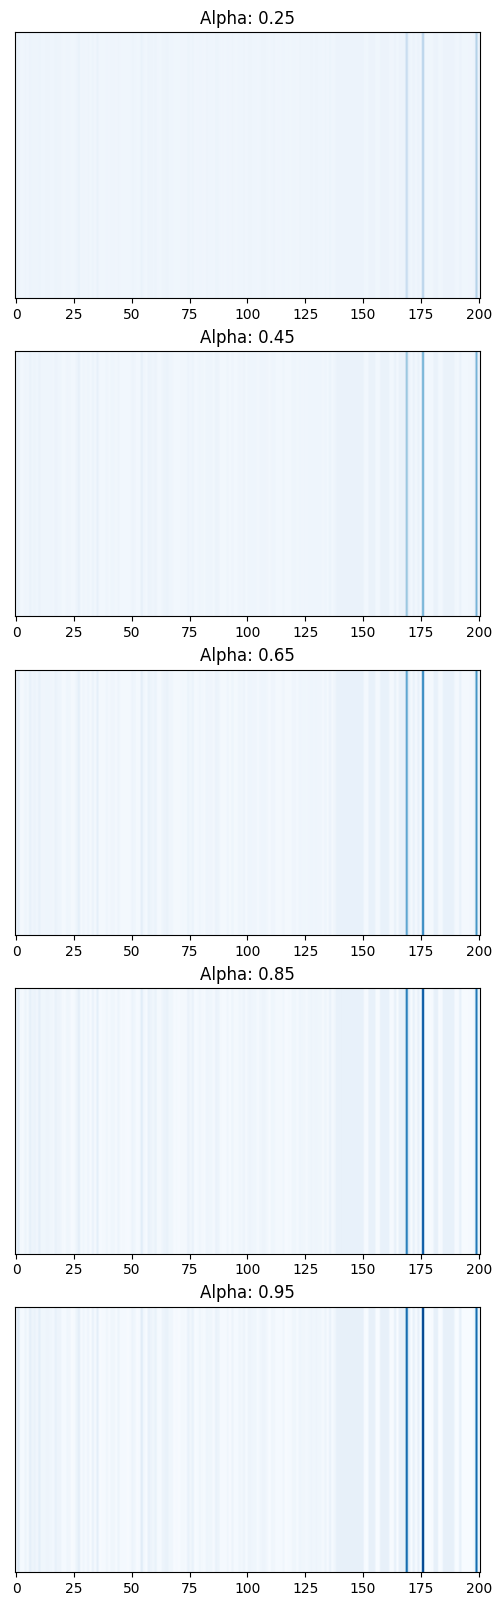

In [115]:
draw_heatmap(alphas, diagonalize_pis)

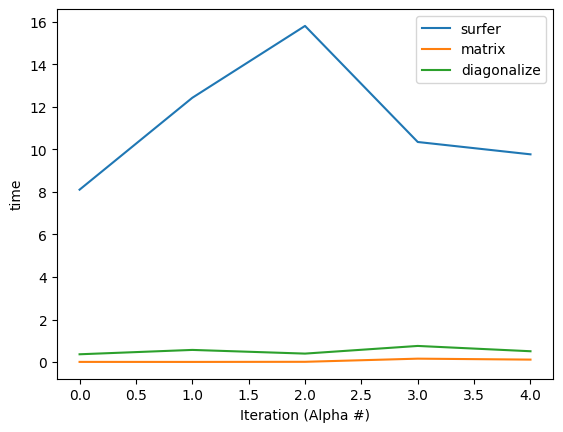

In [119]:
plt.plot(surf_times, label="surfer")
plt.plot(matrix_times, label="matrix")
plt.plot(diagonalize_times, label="diagonalize")
plt.xlabel("Iteration (Alpha #)")
plt.ylabel("time")
plt.legend()

It looks like the fastest method is matrix, but only a bit faster than diagonalize. Both deterministic methods are faster than the random surfer. 

In terms of accuracy, both matrix and diagonalize come to very similar heatmaps, while the random surfer has some variance from both the other method while still having peaks in the same areas on the right side of the heatmap.